# Jet Energy Corrections

## Loading packages and input files

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import correctionlib
import copy

plt.style.use(hep.style.CMS)

In [2]:
fname = "root://cmseos.fnal.gov//store/user/cmsdas/2023/short_exercises/jets/RunIISummer20UL18NanoAODv9/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/130AF209-596A-BA46-BA9E-D8847511BB0F.root"
events = NanoEventsFactory.from_root( fname, schemaclass=NanoAODSchema.v6).events()

## Exercise 1

First, for simplicity, let's apply a simple selection in the jet eta of the jets we are going to study:

In [3]:
events.Jet = events.Jet[ (np.abs(events.Jet.eta)<2.5) ]

Since the jets in our input files are corrected, we will uncorrect them first. Then, again for simplicity, we will include a jet pt selection:

In [4]:
uncorr_jets = copy.deepcopy(events.Jet)
uncorr_jets['pt_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['pt']
uncorr_jets['mass_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['mass']

uncorr_jets = uncorr_jets[(uncorr_jets.pt_raw > 30)]
events.GenJet = events.GenJet[(events.GenJet.pt > 30)]

Let's make the histograms to compare and the plots:

In [5]:
hists_uncorr = (
    hist.Hist.new
    .StrCat(["gen", "reco"], name="jet_type")
    .Reg(100, 0, 1000, name="pt", label='jet pt')
    .Reg(40, -5, 5, name="eta", label='jet eta')
    .Weight()
    .fill(
        jet_type='gen',
        pt=ak.flatten(events.GenJet.pt),
        eta=ak.flatten(events.GenJet.eta)
    )
    .fill(
        jet_type='reco',
        pt=ak.flatten(uncorr_jets.pt_raw),
        eta=ak.flatten(uncorr_jets.eta)
    )
)

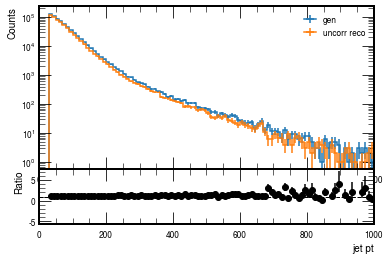

In [6]:
gen = hists_uncorr["gen", :, ::sum]
unc_reco = hists_uncorr["reco", :, ::sum]

fig = plt.gcf()
grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)

main, subplot = gen.plot_ratio(unc_reco, rp_num_label="gen", rp_denom_label="uncorr reco", ax_dict={'main_ax' : main_ax, 'ratio_ax': subplot_ax} )
main_ax.set_yscale('log')

## Exercise 2: Before and after JECs

Applying JECs to uncorrected jets:

In [7]:
jerc_file = '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/JME/2018_UL/jet_jerc.json.gz'
jerc_corr = correctionlib.CorrectionSet.from_file(jerc_file)

uncorr_jets = events.Jet
uncorr_jets['pt_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['pt']
uncorr_jets['mass_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['mass']
uncorr_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, uncorr_jets.pt)[0]
j, nj = ak.flatten(uncorr_jets), ak.num(uncorr_jets)

corr = jerc_corr.compound["Summer19UL18_V5_MC_L1L2L3Res_AK4PFchs"]
flat_jec = corr.evaluate( j['area'], j['eta'], j['pt_raw'], j['rho'] )
jec = ak.unflatten( flat_jec, nj )

corr_jets = copy.deepcopy(uncorr_jets)
corr_jets['jet_energy_correction'] = jec
corr_jets['pt'] = corr_jets.pt_raw * jec
corr_jets['mass'] = corr_jets.mass_raw * jec

corr_jets = corr_jets[ (corr_jets.pt > 30) ]

Let's make the histograms to compare genjets with corrected jets:

In [8]:
hists_corr = (
    hist.Hist.new
    .StrCat(["gen", "reco"], name="jet_type")
    .Reg(100, 0, 1000, name="pt", label='jet pt')
    .Reg(40, -5, 5, name="eta", label='jet eta')
    .Weight()
    .fill(
        jet_type='gen',
        pt=ak.flatten(events.GenJet.pt),
        eta=ak.flatten(events.GenJet.eta)
    )
    .fill(
        jet_type='reco',
        pt=ak.flatten(corr_jets.pt),
        eta=ak.flatten(corr_jets.eta)
    )
)

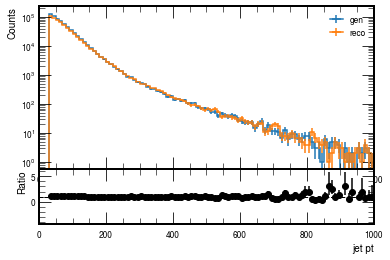

In [9]:
gen = hists_corr["gen",:,:].project("pt")
reco = hists_corr["reco",:,:].project("pt")

fig = plt.gcf()
grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)

main, subplot = gen.plot_ratio(reco, rp_num_label="gen", rp_denom_label="reco", ax_dict={'main_ax' : main_ax, 'ratio_ax': subplot_ax} )
main_ax.set_yscale('log')

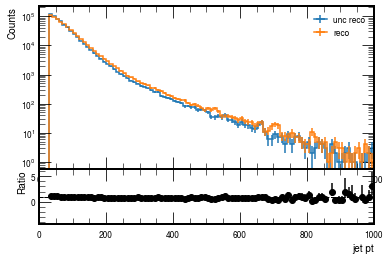

In [10]:
fig = plt.gcf()
grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)

main, subplot = unc_reco.plot_ratio(reco, rp_num_label="unc reco", rp_denom_label="reco", ax_dict={'main_ax' : main_ax, 'ratio_ax': subplot_ax} )
main_ax.set_yscale('log')


## Exercise 3: JEC Uncertainties

Let's apply the JEC uncertainties (one sigma up and down) to the uncorrected jets:

In [11]:
uncorr_jets = events.Jet
uncorr_jets['pt_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['pt']
uncorr_jets['mass_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['mass']
uncorr_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, uncorr_jets.pt)[0]
j, nj = ak.flatten(uncorr_jets), ak.num(uncorr_jets)

### jet corrections
corr = jerc_corr.compound["Summer19UL18_V5_MC_L1L2L3Res_AK4PFchs"]
flat_jec = corr.evaluate( j['area'], j['eta'], j['pt_raw'], j['rho'] )
jec = ak.unflatten( flat_jec, nj )

### jet corrections uncertainties
corr = jerc_corr["Summer19UL18_V5_MC_Total_AK4PFchs"]
flat_jec_unc = corr.evaluate( j['eta'], j['pt_raw'] )
flat_jec_unc_up = np.ones(len(j)) + flat_jec_unc
flat_jec_unc_down = np.ones(len(j)) - flat_jec_unc

jec_unc_up = ak.unflatten( flat_jec_unc_up, nj )
jec_unc_down = ak.unflatten( flat_jec_unc_down, nj )

corr_jets = copy.deepcopy(uncorr_jets)
corr_jets['jet_energy_correction'] = jec
corr_jets['pt'] = corr_jets.pt_raw * jec
corr_jets['mass'] = corr_jets.mass_raw * jec

corr_jets['pt_unc_up'] = corr_jets.pt_raw * jec_unc_up
corr_jets['pt_unc_down'] = corr_jets.pt_raw * jec_unc_down

corr_jets = corr_jets[ (corr_jets.pt > 30) ]

Let's make the plots to compare:

In [12]:
hists_unc = (
    hist.Hist.new
    .StrCat(["nominal", "up", 'down'], name="unc")
    .Reg(100, 0, 1000, name="pt", label='jet pt')
    .Weight()
    .fill(
        unc='nominal',
        pt=ak.flatten(corr_jets.pt),
    )
    .fill(
        unc='up',
        pt=ak.flatten(corr_jets.pt_unc_up),
    )
    .fill(
        unc='down',
        pt=ak.flatten(corr_jets.pt_unc_down),
    )
)

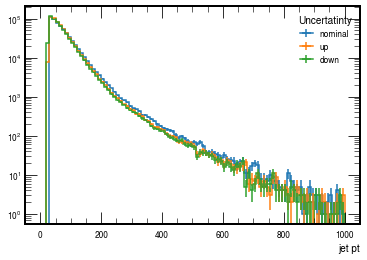

In [13]:
fig, ax = plt.subplots()
hists_unc.plot1d(ax=ax)
ax.legend(title="Uncertatinty")
ax.set_yscale("log")

## Your turn

You can check different the JEC uncertainties variations for other jet variables